In [1]:
import networkit as nk
import networkx as nx
import pickle
from graph_utils import *

In [2]:
import igraph as ig

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [79]:
from scipy.stats import wilcoxon

# helper functions

In [4]:
def go_through_text_with_NF(text: str, graph: ig.Graph, nodes: list) -> list:
    '''
    Convert text to path on igraph graph

    Parameters
    ----------
    text: str
    graph: nx.classes.graph.Graph

    Returns
    -------
    path_edges : list

    text = "word_1 word_2 ... word_n"
    Shortest path from word_i to word_i+1 is nx.dijkstra_path(graph, word_i, word_i+1)
    Shortest paths through text [(word_1, word_1_1, word_1_2, ..., word_1_n, word_2),
                                 (word_2, ..., word_3),
                                 (word_3, ..., word_4) ..., (word_n-1, ..., word_n)]
    '''
    text = text.split()
    path_edges = []
    current_word = text[0]
    file_ = open("At_stream_go_through_text.txt", 'w')
    for word in tqdm(text[1:], file=file_):
        if current_word not in nodes:
            path_edges.append(("NF", word))
            current_word = word
            continue
        if word not in nodes:
            path_edges.append((current_word, "NF"))
            continue
        if word in graph.neighbors(nodes.index(current_word)):
            path_edges.append((current_word, word))
            file_.write('in path_edges!!!')
        else:
            try:
                shortest_path = tuple(graph.get_shortest_paths(nodes.index(current_word),nodes.index(word),weights='weight')[0])
                path_edges.append(shortest_path)
            except:
                path_edges.append(f"No path {current_word} -- {word}")
        current_word = word
    file_.close()
    return path_edges


In [5]:
def return_Arrays_of_path_length_withNFAndLimit(human_file_path,bot_file_path,graph,dia,limit):
    bot_paths = []
    human_paths = []
    counter = 0
    names = []
    for v in graph.vs:
        names.append(v['_nx_name'])
    with open(human_file_path) as file_1, open(bot_file_path) as file_2: 
        human = file_1.readlines()
        bot = file_2.readlines()
        for text1, text2 in zip(human, bot):
            counter += 1
            text2 = ' '.join(text2.split()[:limit])
            text1 = ' '.join(text1.split()[:len(text2.split())])
            path_length_text_1 = 0
            path_length_text_2 = 0
            for path in go_through_text_with_NF(text1 , graph,names):
                if "NF" in path:
                    path_length_text_1+=dia
                else:
                    for index in range(1,len(path)):
                        path_length_text_1+= graph.es[graph.get_eid(path[index-1],path[index])]['weight']
            for path in go_through_text_with_NF(text2 , graph,names):
                if "NF" in path:
                    path_length_text_2+=dia
                else:
                    for index in range(1,len(path)):
                        path_length_text_1+= graph.es[graph.get_eid(path[index-1],path[index])]['weight']

            human_paths.append(path_length_text_1)
            bot_paths.append(path_length_text_2)
    return np.array(human_paths) , np.array(bot_paths)

In [6]:
def convert_text_shortest_paths_to_text_words_path_num2word(shortest_paths: list,names: list) -> list:
    '''
    Convert text shortest paths to text words path

    Parameters
    ----------
    shortest_paths: list

    Returns
    -------
    words_path : list

    shortest_paths = [(word_1, word_1_1, word_1_2, ..., word_1_n, word_2),
                      (word_2, ..., word_3),
                      (word_3, ..., word_4) ..., (word_n-1, ..., word_n)]
    words_path = [word_1, word_1_1, word_1_2, word_1_3,
                   ...,
                  word_n-1, word_n-1_1,
                   ...,
                  word_n-1_k, word_n]
    '''
    words_path = []
    try:
        for number in shortest_paths[0]:
            words_path.append(names[number])
        for short_path in shortest_paths[1:]:
            for number in short_path[1:]:
                words_path.append(names[number])
    except:
        words_path.append(0)
    return words_path

In [7]:
def calculate_average_centrality_for_path(path,centrality_dic):
    centrality_val = []
    #min_val = min(centrality_dic.values())
    for word in path:
        if word not in centrality_dic.keys():
            centrality_val.append(0.0)
        else:
            centrality_val.append(centrality_dic[word])
    #return np.average(centrality_val)
    return sum(centrality_val)

In [8]:
def return_Arrys_of_centralites(human_file_path , bot_file_path , graph,centrality_dic,limit):
    bot_average_centrality = []
    human_average_centrality = []
    names = []
    for v in graph.vs:
        names.append(v['_nx_name'])
    with open(human_file_path) as file_1, open(bot_file_path) as file_2: 
        human = file_1.readlines()
        bot = file_2.readlines()
        for text1, text2 in zip(human, bot):
            text2 = ' '.join(text2.split()[:limit])
            text1 = ' '.join(text1.split()[:len(text2.split())])
            cen_1 = calculate_average_centrality_for_path(convert_text_shortest_paths_to_text_words_path_num2word(go_through_text_without_NF(text1,graph,names),names),centrality_dic)
            cen_2 = calculate_average_centrality_for_path(convert_text_shortest_paths_to_text_words_path_num2word(go_through_text_without_NF(text2,graph,names),names),centrality_dic)
            human_average_centrality.append(cen_1/limit)
            bot_average_centrality.append(cen_2/limit)
    bot_average_centrality = np.array(bot_average_centrality)
    human_average_centrality = np.array(human_average_centrality)
    return human_average_centrality,bot_average_centrality

In [9]:
def go_through_text_without_NF(text: str, graph: ig.Graph, nodes: list) -> list:
    text = text.split()
    path_edges = []
    current_word = text[0]
    file_ = open("At_stream_go_through_text.txt", 'w')
    for word in tqdm(text[1:], file=file_):
        if current_word not in nodes:
            #path_edges.append(("NF", word))
            current_word = word
            continue
        if word not in nodes:
            #path_edges.append((current_word, "NF"))
            continue
        if word in graph.neighbors(nodes.index(current_word)):
            path_edges.append((nodes.index(current_word),nodes.index(word)))
            file_.write('in path_edges!!!')
        else:
            try:
                shortest_path = tuple(graph.get_shortest_paths(nodes.index(current_word),nodes.index(word),weights='weight')[0])
                path_edges.append(shortest_path)
            except:
                path_edges.append(f"No path {current_word} -- {word}")
        current_word = word
    file_.close()
    return path_edges

# SVD

In [10]:
with open('Atikamekw_Gabriel_Graph_SVD_1gram_6.pkl', 'rb') as inp:
    At_graph_svd_1g6 = pickle.load(inp)

In [11]:
gabriel = At_graph_svd_1g6.get_networkx_graph()

100%|██████████| 31046/31046 [00:00<00:00, 67855.55it/s]


In [12]:
h = ig.Graph.from_networkx(gabriel)

In [13]:
with open('Atikamekw_Gabriel_Graph_SVD_1gram_6_ig.pkl', 'wb') as outp:
        pickle.dump(h, outp, pickle.HIGHEST_PROTOCOL)

In [14]:
with open('Atikamekw_Gabriel_Graph_SVD_1gram_6_ig.pkl', 'rb') as inp:
        h = pickle.load(inp)

In [15]:
print("SVD Number of edges:", h.ecount())

SVD Number of edges: 31046


In [16]:
print("SVD Number of vertices:", h.vcount())

SVD Number of vertices: 4948


In [17]:
print ("SVD diamter is : ", h.diameter())

SVD diamter is :  19


In [19]:
print ("SVD weighted diamter is : ", h.diameter(weights="weight"))

SVD weighted diamter is :  13.016656306181819


In [18]:
print ("SVD radius is : ", h.radius())

SVD radius is :  10


In [20]:
print ("SVD ASP (average shortest paths) is : ", np.mean(h.shortest_paths()))

C:\Users\kakas\AppData\Local\Temp\ipykernel_11452\1682685188.py:1: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  print ("SVD ASP (average shortest paths) is : ", np.mean(h.shortest_paths()))


SVD ASP (average shortest paths) is :  7.20518771129202


In [21]:
print ("SVD weighted ASP (average shortest paths) is : ", np.mean(h.shortest_paths(weights="weight")))

C:\Users\kakas\AppData\Local\Temp\ipykernel_11452\3549933456.py:1: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  print ("SVD weighted ASP (average shortest paths) is : ", np.mean(h.shortest_paths(weights="weight")))


SVD weighted ASP (average shortest paths) is :  0.08706383063485514


In [22]:
print ("SVD CC (clustering coefficient) is : ", h.transitivity_undirected())

SVD CC (clustering coefficient) is :  0.2934859105368353


In [23]:
print ("SVD ACC (Average clustering coefficient) is : ", h.transitivity_avglocal_undirected())

SVD ACC (Average clustering coefficient) is :  0.319763465304222


In [24]:
print ("SVD Degree Assortativity is : ",h.assortativity_degree())

SVD Degree Assortativity is :  0.40139523667996196


In [25]:
import matplotlib
import matplotlib.pyplot as plt

In [26]:
x=h.degree_distribution()
y = x.bins()
bins = []
for y in x.bins():
    bins.append(y)

In [27]:
x = h.degree_distribution()
print (x)

N = 4948, mean +- sd: 12.5489 +- 5.2328
Each * represents 6 items
[ 1,  2):  (5)
[ 2,  3): ******* (43)
[ 3,  4): ************ (72)
[ 4,  5): ***************** (106)
[ 5,  6): **************************** (168)
[ 6,  7): *********************************** (214)
[ 7,  8): ******************************************* (263)
[ 8,  9): *********************************************** (287)
[ 9, 10): ******************************************************* (334)
[10, 11): ************************************************************ (365)
[11, 12): *********************************************************** (357)
[12, 13): ************************************************************** (374)
[13, 14): ************************************************************ (363)
[14, 15): ******************************************************** (336)
[15, 16): **************************************************** (314)
[16, 17): **************************************** (244)
[17, 18): ***********************

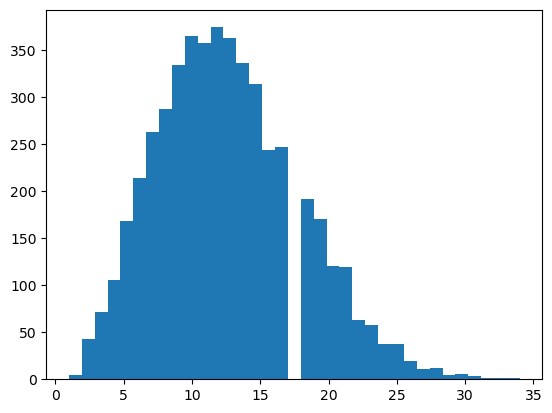

In [28]:
bins= 35
plt.hist(h.degree(), bins)
plt.show()

In [69]:
# with open('Atikamekw_Gabriel_Graph_SVD_1gram_6_ig.pkl', 'wb') as outp:
#     pickle.dump(h, outp, pickle.HIGHEST_PROTOCOL)
# #h.save("./Arabic_Gabriel_Graph_sample1%_CBOW_1gram_6_ig.pkl")

In [29]:
with open('Atikamekw_Gabriel_Graph_SVD_1gram_6_ig.pkl', 'rb') as inp:
    g = pickle.load(inp)

In [30]:
names = []
for v in g.vs:
    #print(v)
    names.append(v['_nx_name'])
print (names)

['mockinikate', 'atamitow', 'tapowe', 'mar', 'itekopo', 'metowemew', 'pakoseritcikaniw', 'wapatahew', 'miskw', 'aikew', 'iskwatoww', 'mockinakiniwiw', 'opi', 'kicepw', 'irikokw', 'cikopw', 'kiskinohamakerinw', 'notapwaniw', 'otapinam', 'kicteritam', 'nisakiw', 'sept', 'kitaskin', 'omist', 'wicamakaniwiw', 'nitawikihakaniwiw', 'kimiw', 'ositin', 'cikopisk', 'mitcinani', 'ciko', 'micikamaw', 'kaskeritakosw', 'namepar', 'otanisiw', 'cakw', 'ocawapeki', 'petameww', 'kanehsaw', 'iskweiw', 'tenowesiw', 'tcimataw', 'takonokisiw', 'witcewikw', 'kiskeritackosw', 'ototokon', 'icinakos', 'matakan', 'kicipaw', 'masinihikaniw', 'kiskinohamew', 'otirapatcitcikanw', 'waseskonw', 'witica', 'wakwew', 'askiwacit', 'irapatcitc', 'maskw', 'nokom', 'pwat', 'kickahaskwew', 'pirea', 'kicik', 'matisiw', 'itikitw', 'miroska', 'tipiskipisimam', 'asitat', 'kictapit', 'mikonowecw', 'waiesiw', 'tip', 'kinokos', 'atowekamew', 'kict', 'niportc', 'piokaparin', 'aititoskaniwo', 'pakac', 'akotitakaniw', 'mackikiwo', 'a

In [31]:
#print(h.closeness(0,weights="weight")) 
degree = h.degree()
degree_dic= {}
for key,value in zip(names, degree):
    degree_dic[key] = value
print(degree_dic)
with open('Atikamekw_degree_SVD_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(degree_dic, outp, pickle.HIGHEST_PROTOCOL)

{'mockinikate': 18, 'atamitow': 22, 'tapowe': 10, 'mar': 9, 'itekopo': 11, 'metowemew': 14, 'pakoseritcikaniw': 10, 'wapatahew': 21, 'miskw': 10, 'aikew': 14, 'iskwatoww': 17, 'mockinakiniwiw': 18, 'opi': 28, 'kicepw': 21, 'irikokw': 9, 'cikopw': 11, 'kiskinohamakerinw': 19, 'notapwaniw': 20, 'otapinam': 22, 'kicteritam': 21, 'nisakiw': 15, 'sept': 21, 'kitaskin': 22, 'omist': 18, 'wicamakaniwiw': 11, 'nitawikihakaniwiw': 16, 'kimiw': 16, 'ositin': 11, 'cikopisk': 12, 'mitcinani': 19, 'ciko': 16, 'micikamaw': 18, 'kaskeritakosw': 17, 'namepar': 13, 'otanisiw': 5, 'cakw': 6, 'ocawapeki': 14, 'petameww': 16, 'kanehsaw': 21, 'iskweiw': 20, 'tenowesiw': 13, 'tcimataw': 13, 'takonokisiw': 11, 'witcewikw': 12, 'kiskeritackosw': 22, 'ototokon': 19, 'icinakos': 19, 'matakan': 16, 'kicipaw': 17, 'masinihikaniw': 20, 'kiskinohamew': 24, 'otirapatcitcikanw': 13, 'waseskonw': 13, 'witica': 9, 'wakwew': 24, 'askiwacit': 10, 'irapatcitc': 8, 'maskw': 12, 'nokom': 10, 'pwat': 8, 'kickahaskwew': 14, '

In [32]:
#print(h.closeness(0,weights="weight")) 
cc = h.closeness(weights="weight")

In [33]:
cc_dic_w = {}
for key,value in zip(names, cc):
    cc_dic_w[key] = value
print(cc_dic_w)
with open('Atikamekw_CCW_SVD_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(cc_dic_w, outp, pickle.HIGHEST_PROTOCOL)

{'mockinikate': 19.337905464221826, 'atamitow': 19.066227559299595, 'tapowe': 19.513162271820047, 'mar': 19.58772679453539, 'itekopo': 18.330374832898084, 'metowemew': 18.495136248676534, 'pakoseritcikaniw': 19.69439174676104, 'wapatahew': 19.89011247981023, 'miskw': 19.661000416359318, 'aikew': 19.660833883464985, 'iskwatoww': 19.07011802789117, 'mockinakiniwiw': 19.17352616610307, 'opi': 18.727641938218603, 'kicepw': 19.11276455011982, 'irikokw': 19.107759110675875, 'cikopw': 19.208650129443107, 'kiskinohamakerinw': 19.577373844512824, 'notapwaniw': 19.491367963392868, 'otapinam': 18.711332511362617, 'kicteritam': 18.51220482825718, 'nisakiw': 19.284944802705844, 'sept': 19.237562768285464, 'kitaskin': 19.23443999855004, 'omist': 19.326832386427387, 'wicamakaniwiw': 19.64191618572768, 'nitawikihakaniwiw': 19.916795240079708, 'kimiw': 10.928461788827219, 'ositin': 11.088630554582872, 'cikopisk': 16.584241925585374, 'mitcinani': 16.643399277577334, 'ciko': 19.128827618111025, 'micikama

In [34]:
#print(h.closeness(0,weights="weight")) 
cc = h.closeness()
cc_dic= {}
for key,value in zip(names, cc):
    cc_dic[key] = value
print(cc_dic)
with open('Atikamekw_CC_SVD_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(cc_dic, outp, pickle.HIGHEST_PROTOCOL)

{'mockinikate': 0.1572572954415411, 'atamitow': 0.17674800814605737, 'tapowe': 0.13035229638217702, 'mar': 0.13338546160483175, 'itekopo': 0.13949357094518386, 'metowemew': 0.1533905925397662, 'pakoseritcikaniw': 0.13604488078541374, 'wapatahew': 0.1520609842313958, 'miskw': 0.13798778276756576, 'aikew': 0.13265224036682488, 'iskwatoww': 0.13788394001895313, 'mockinakiniwiw': 0.13831185170688065, 'opi': 0.15614544536329777, 'kicepw': 0.1465387007909002, 'irikokw': 0.14577010342693816, 'cikopw': 0.12790547353724435, 'kiskinohamakerinw': 0.155131863652043, 'notapwaniw': 0.1382770572450805, 'otapinam': 0.17441737474879243, 'kicteritam': 0.16258586124166036, 'nisakiw': 0.14664295242329925, 'sept': 0.15141405484818804, 'kitaskin': 0.17659027629042623, 'omist': 0.17305068737538043, 'wicamakaniwiw': 0.14578299051099192, 'nitawikihakaniwiw': 0.1601178146038322, 'kimiw': 0.13431620102630937, 'ositin': 0.1286974166861781, 'cikopisk': 0.1439294754298682, 'mitcinani': 0.1340904778684303, 'ciko': 0

In [35]:
#print(h.closeness(0,weights="weight")) 
bc = h.betweenness()
bc_dic= {}
for key,value in zip(names, bc):
    bc_dic[key] = value
print(bc_dic)
with open('Atikamekw_bC_SVD_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(bc_dic, outp, pickle.HIGHEST_PROTOCOL)

{'mockinikate': 17102.13887598905, 'atamitow': 122420.86570319663, 'tapowe': 577.5561872425576, 'mar': 450.47371894435094, 'itekopo': 270.19276446545354, 'metowemew': 9968.52177469006, 'pakoseritcikaniw': 3350.7108025477714, 'wapatahew': 14085.795032827347, 'miskw': 3511.4881524281886, 'aikew': 1731.898789469427, 'iskwatoww': 12128.402088605168, 'mockinakiniwiw': 1858.5236221408895, 'opi': 16176.723153499912, 'kicepw': 3625.2214631038337, 'irikokw': 20426.90402758559, 'cikopw': 7376.462556492585, 'kiskinohamakerinw': 32509.328071158376, 'notapwaniw': 3433.4708408325073, 'otapinam': 24967.10570754245, 'kicteritam': 15323.797564462293, 'nisakiw': 1338.6290814456077, 'sept': 4796.386343854847, 'kitaskin': 47457.899773965386, 'omist': 32362.094441491252, 'wicamakaniwiw': 2341.071618658712, 'nitawikihakaniwiw': 13602.342068455857, 'kimiw': 13633.571535887844, 'ositin': 4009.179358720795, 'cikopisk': 2121.3501110643297, 'mitcinani': 2316.15038134369, 'ciko': 31760.70861828294, 'micikamaw': 3

In [36]:
bc = h.betweenness(weights="weight")
bc_dic_w= {}
for key,value in zip(names, bc):
    bc_dic_w[key] = value
print(bc_dic_w)
with open('Atikamekw_bCw_SVD_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(bc_dic_w, outp, pickle.HIGHEST_PROTOCOL)

{'mockinikate': 44287.0, 'atamitow': 16250.0, 'tapowe': 34239.0, 'mar': 47244.0, 'itekopo': 17380.0, 'metowemew': 42185.0, 'pakoseritcikaniw': 10115.0, 'wapatahew': 65618.0, 'miskw': 28014.0, 'aikew': 47289.0, 'iskwatoww': 23928.0, 'mockinakiniwiw': 8553.0, 'opi': 32129.0, 'kicepw': 32723.0, 'irikokw': 9864.0, 'cikopw': 85846.0, 'kiskinohamakerinw': 12571.0, 'notapwaniw': 49753.0, 'otapinam': 25141.0, 'kicteritam': 201009.0, 'nisakiw': 11463.0, 'sept': 6690.0, 'kitaskin': 35191.0, 'omist': 47509.0, 'wicamakaniwiw': 6330.0, 'nitawikihakaniwiw': 48942.0, 'kimiw': 43161.0, 'ositin': 11883.0, 'cikopisk': 1498.0, 'mitcinani': 13587.0, 'ciko': 15084.0, 'micikamaw': 13070.0, 'kaskeritakosw': 5079.0, 'namepar': 1945.0, 'otanisiw': 2442.0, 'cakw': 32181.0, 'ocawapeki': 24048.0, 'petameww': 71687.0, 'kanehsaw': 35442.0, 'iskweiw': 41726.0, 'tenowesiw': 1081.0, 'tcimataw': 14496.0, 'takonokisiw': 10097.0, 'witcewikw': 10766.0, 'kiskeritackosw': 25590.0, 'ototokon': 10335.0, 'icinakos': 13132.0, '

### weighted path length for texts

In [80]:
with open('Atikamekw_Gabriel_Graph_SVD_1gram_6_ig.pkl', 'rb') as inp:
    graph = pickle.load(inp)

In [81]:
weights = []
for e in graph.es:
    weights.append(e['weight'])
print (max(weights))
diameter = max(weights) +1

5.057006252968523


In [82]:
#diameter = 19
limit = 500
human, bot = return_Arrays_of_path_length_withNFAndLimit( "./test_original_corpus.txt", "./test_bot_corpus.txt",graph,diameter,limit)
#human, bot =return_Arrays_of_path_length_withNFAndLimit( "./test_original_corpus.txt", "./test_bot_corpus.txt",g,diameter,limit)

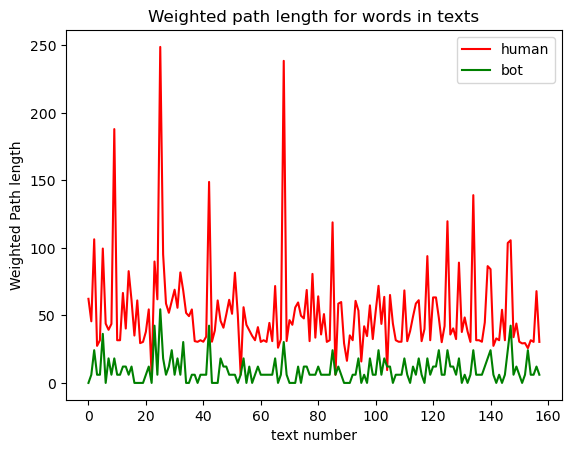

In [83]:
X = np.arange(0,len(human))
plt.plot(X, human, color='r', label='human')
plt.plot(X, bot, color='g', label='bot')

        # Naming the x-axis, y-axis and the whole graph
plt.xlabel("text number")
plt.ylabel("Weighted Path length")
plt.title("Weighted path length for words in texts")

        # Adding legend, which helps us recognize the curve according to it's color
plt.legend()
plt.savefig('Atikamekw_Weighted_path_length_SVD_500.pdf')
        # To load the display window
plt.show()

In [84]:
print ('Wilcoxon Signed-Rank Test for human and bots samples')
stat, p = wilcoxon(human, bot)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Wilcoxon Signed-Rank Test for human and bots samples
Statistics=2.000, p=0.000
Different distribution (reject H0)


### weighted closness centrality

In [85]:
with open('Atikamekw_CCW_SVD_1gram_6_ig.pkl', 'rb') as outp:
    cc_dic = pickle.load(outp)

In [86]:
limit = 500
human , bot = return_Arrys_of_centralites( "./test_original_corpus.txt", "./test_bot_corpus.txt",graph,cc_dic,limit)
#human , bot = return_Arrys_of_centralites( "./test_original_corpus.txt", "./test_bot_corpus.txt",g,cc_dic,limit)

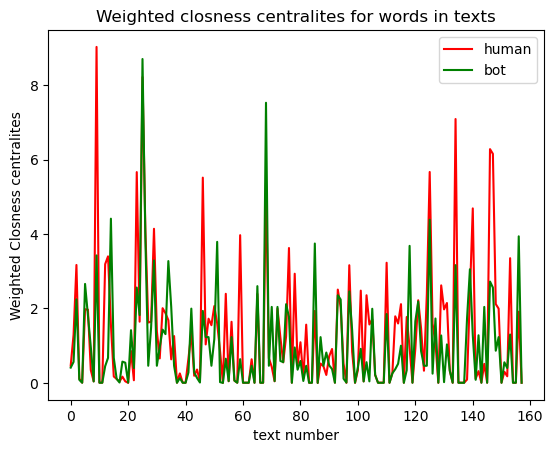

In [87]:
X = np.arange(0,len(human))
plt.plot(X, human, color='r', label='human')
plt.plot(X, bot, color='g', label='bot')

        # Naming the x-axis, y-axis and the whole graph
plt.xlabel("text number")
plt.ylabel("Weighted Closness centralites")
plt.title("Weighted closness centralites for words in texts")

        # Adding legend, which helps us recognize the curve according to it's color
plt.legend()
plt.savefig('Atikamekw_Weighted_cc_SVD_500.pdf')
        # To load the display window
plt.show()

In [88]:
print ('Wilcoxon Signed-Rank Test for human and bots samples')
stat, p = wilcoxon(human, bot)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Wilcoxon Signed-Rank Test for human and bots samples
Statistics=4330.000, p=0.002
Different distribution (reject H0)


### Betweeness Centrality 

In [89]:
with open('Atikamekw_bCw_SVD_1gram_6_ig.pkl', 'rb') as outp:
    bc_dic = pickle.load(outp)

In [90]:
limit = 500
human , bot = return_Arrys_of_centralites( "./test_original_corpus.txt", "./test_bot_corpus.txt",graph,bc_dic,limit)

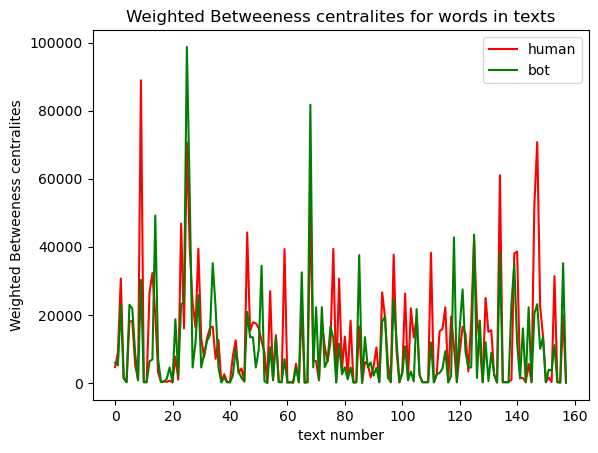

In [91]:
X = np.arange(0,len(human))
plt.plot(X, human, color='r', label='human')
plt.plot(X, bot, color='g', label='bot')

        # Naming the x-axis, y-axis and the whole graph
plt.xlabel("text number")
plt.ylabel("Weighted Betweeness centralites")
plt.title("Weighted Betweeness centralites for words in texts")

        # Adding legend, which helps us recognize the curve according to it's color
plt.legend()
plt.savefig('Atikamekw_Weighted_bc_SVD_500.pdf')
        # To load the display window
plt.show()


In [92]:
print ('Wilcoxon Signed-Rank Test for human and bots samples')
stat, p = wilcoxon(human, bot)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Wilcoxon Signed-Rank Test for human and bots samples
Statistics=4660.500, p=0.010
Different distribution (reject H0)


# CBOW

In [93]:
with open('Atikamekw_Gabriel_Graph_CBOW_1gram_6.pkl', 'rb') as inp:
    At_graph_svd_1g6 = pickle.load(inp)

In [94]:
gabriel = At_graph_svd_1g6.get_networkx_graph()

100%|██████████| 216434/216434 [00:02<00:00, 77109.27it/s]


In [95]:
g = ig.Graph.from_networkx(gabriel)

In [96]:
with open('Atikamekw_Gabriel_Graph_CBOW_1gram_6_ig.pkl', 'rb') as inp:
    g = pickle.load(inp)

In [52]:
print("CBOW Number of edges:", g.ecount())

CBOW Number of edges: 216434


In [53]:
print("CBOW Number of vertices:", g.vcount())

CBOW Number of vertices: 11493


In [54]:
print ("CBOW diamter is : ", g.diameter())

CBOW diamter is :  19


In [56]:
print ("CBOW weighted diamter is : ", g.diameter(weights="weight"))

CBOW weighted diamter is :  14.983017961114747


In [55]:
print ("CBOW radius is : ", g.radius())

CBOW radius is :  10


In [57]:
print ("CBOW ASP (average shortest paths) is : ", np.mean(g.shortest_paths()))

C:\Users\kakas\AppData\Local\Temp\ipykernel_11452\3076196244.py:1: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  print ("CBOW ASP (average shortest paths) is : ", np.mean(g.shortest_paths()))


CBOW ASP (average shortest paths) is :  4.840469174700471


In [58]:
print ("CBOW weighted ASP (average shortest paths) is : ", np.mean(g.shortest_paths(weights="weight")))

C:\Users\kakas\AppData\Local\Temp\ipykernel_11452\3998456253.py:1: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  print ("CBOW weighted ASP (average shortest paths) is : ", np.mean(g.shortest_paths(weights="weight")))


CBOW weighted ASP (average shortest paths) is :  0.7782938999070338


In [59]:
print ("CBOW CC (clustering coefficient) is : ", g.transitivity_undirected())

CBOW CC (clustering coefficient) is :  0.24066731724456805


In [60]:
print ("CBOW ACC (Average clustering coefficient) is : ", g.transitivity_avglocal_undirected())

CBOW ACC (Average clustering coefficient) is :  0.27406932013369073


In [61]:
print ("CBOW Degree Assortativity is : ",g.assortativity_degree())

CBOW Degree Assortativity is :  0.4017611115902421


In [63]:
x=g.degree_distribution()
y = x.bins()
bins = []
for y in x.bins():
    bins.append(y)

In [64]:
print(x)

N = 11493, mean +- sd: 37.6636 +- 14.5571
Each * represents 5 items
[  2,   3):  (2)
[  3,   4):  (4)
[  4,   5): ** (14)
[  5,   6): *** (18)
[  6,   7): **** (23)
[  7,   8): *** (19)
[  8,   9): ****** (32)
[  9,  10): ********* (45)
[ 10,  11): ******** (44)
[ 11,  12): *********** (55)
[ 12,  13): ************** (71)
[ 13,  14): **************** (80)
[ 14,  15): ******************** (104)
[ 15,  16): ********************* (107)
[ 16,  17): ****************** (92)
[ 17,  18): ************************* (125)
[ 18,  19): ************************* (127)
[ 19,  20): ***************************** (148)
[ 20,  21): ****************************** (154)
[ 21,  22): *************************************** (196)
[ 22,  23): ********************************************* (226)
[ 23,  24): ********************************************* (227)
[ 24,  25): ****************************************** (211)
[ 25,  26): *********************************************** (239)
[ 26,  27): *****************

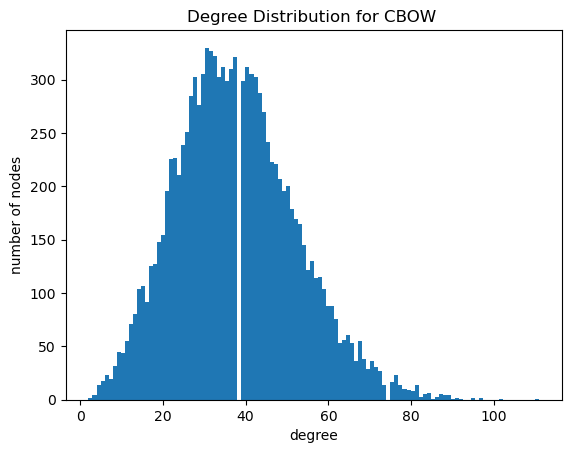

In [62]:
bins= 112
plt.hist(g.degree(), bins)
plt.title("Degree Distribution for CBOW ")
plt.xlabel("degree")
plt.ylabel("number of nodes")
#plt.show()
plt.savefig('Atikamekw_Degree_Distribution__SVD_500.pdf')

In [63]:
# with open('Atikamekw_Gabriel_Graph_CBOW_1gram_6_ig.pkl', 'wb') as outp:
#     pickle.dump(g, outp, pickle.HIGHEST_PROTOCOL)
# #h.save("./Arabic_Gabriel_Graph_sample1%_CBOW_1gram_6_ig.pkl")

In [64]:
names = []
for v in g.vs:
    names.append(v['_nx_name'])

In [65]:
degree = g.degree()
degree_dic= {}
for key,value in zip(names, degree):
    degree_dic[key] = value
with open('Atikamekw_degree_CBOW_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(degree_dic, outp, pickle.HIGHEST_PROTOCOL)

In [66]:
cc = g.closeness(weights="weight")
cc_dic_w = {}
for key,value in zip(names, cc):
    cc_dic_w[key] = value
with open('Atikamekw_CCW_CBOW_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(cc_dic_w, outp, pickle.HIGHEST_PROTOCOL)

In [67]:
cc = g.closeness()
cc_dic= {}
for key,value in zip(names, cc):
    cc_dic[key] = value
with open('Atikamekw_CC_CBOW_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(cc_dic, outp, pickle.HIGHEST_PROTOCOL)

In [68]:
bc = g.betweenness()
bc_dic= {}
for key,value in zip(names, bc):
    bc_dic[key] = value
with open('Atikamekw_BC_CBOW_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(bc_dic, outp, pickle.HIGHEST_PROTOCOL)

In [69]:
bc = g.betweenness(weights="weight")
bc_dic_w= {}
for key,value in zip(names, bc):
    bc_dic_w[key] = value
with open('Atikamekw_BCW_CBOW_1gram_6_ig.pkl', 'wb') as outp:
    pickle.dump(bc_dic_w, outp, pickle.HIGHEST_PROTOCOL)

### weighted path length for texts

In [97]:
weights = []
for e in g.es:
    weights.append(e['weight'])
print (max(weights))

4.347113497725032


In [98]:
diameter = max(weights)+1
limit = 200
human, bot =return_Arrays_of_path_length_withNFAndLimit( "./test_original_corpus.txt", "./test_bot_corpus.txt",g,diameter,limit)

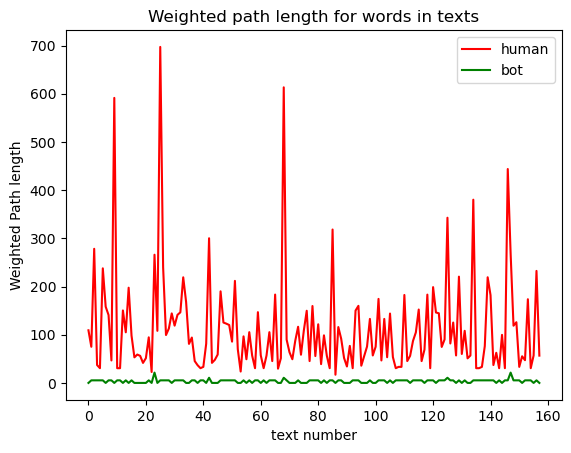

In [99]:
X = np.arange(0,len(human))
plt.plot(X, human, color='r', label='human')
plt.plot(X, bot, color='g', label='bot')

        # Naming the x-axis, y-axis and the whole graph
plt.xlabel("text number")
plt.ylabel("Weighted Path length")
plt.title("Weighted path length for words in texts")

        # Adding legend, which helps us recognize the curve according to it's color
plt.legend()

        # To load the display window
plt.savefig('Atikamekw_Closness_Centrality_SVD.pdf')
#plt.show()

In [100]:
print ('Wilcoxon Signed-Rank Test for human and bots samples')
stat, p = wilcoxon(human, bot)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Wilcoxon Signed-Rank Test for human and bots samples
Statistics=0.000, p=0.000
Different distribution (reject H0)


### weighted closness centrality

In [101]:
with open('Atikamekw_CCW_CBOW_1gram_6_ig.pkl', 'rb') as outp:
    cc_dic = pickle.load(outp)

In [102]:
limit = 200
human , bot = return_Arrys_of_centralites( "./test_original_corpus.txt", "./test_bot_corpus.txt",g,cc_dic,limit)

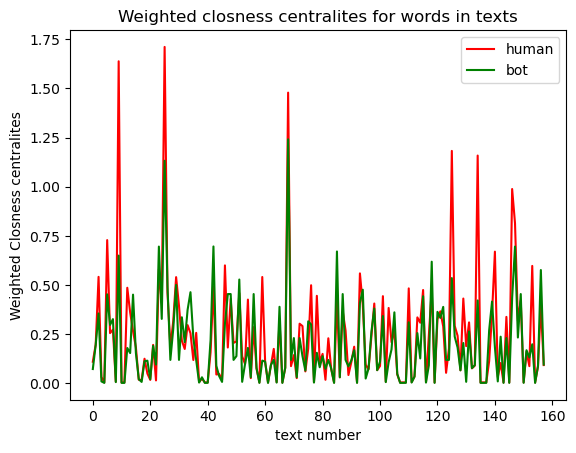

In [103]:
X = np.arange(0,len(human))
plt.plot(X, human, color='r', label='human')
plt.plot(X, bot, color='g', label='bot')

        # Naming the x-axis, y-axis and the whole graph
plt.xlabel("text number")
plt.ylabel("Weighted Closness centralites")
plt.title("Weighted closness centralites for words in texts")

        # Adding legend, which helps us recognize the curve according to it's color
plt.legend()

        # To load the display window
#plt.show()
plt.savefig('Atikamekw_Weighted_path_SVD.pdf')

In [104]:
print ('Wilcoxon Signed-Rank Test for human and bots samples')
stat, p = wilcoxon(human, bot)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Wilcoxon Signed-Rank Test for human and bots samples
Statistics=4822.000, p=0.021
Different distribution (reject H0)


### Betweeness Centrality

In [105]:
with open('Atikamekw_BCW_CBOW_1gram_6_ig.pkl', 'rb') as outp:
    bc_dic = pickle.load(outp)

In [106]:
limit = 200
human , bot = return_Arrys_of_centralites( "./test_original_corpus.txt", "./test_bot_corpus.txt",g,bc_dic,limit)

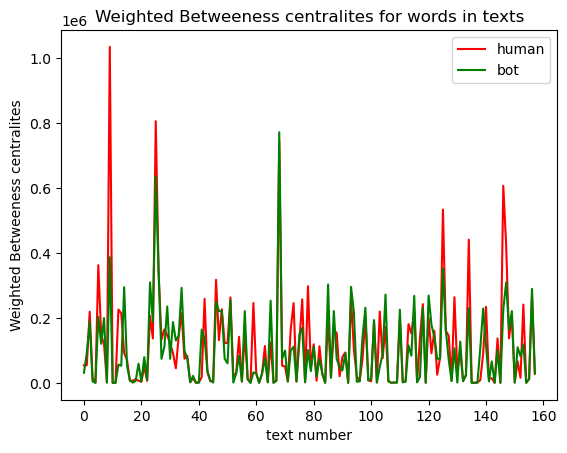

In [107]:
X = np.arange(0,len(human))
plt.plot(X, human, color='r', label='human')
plt.plot(X, bot, color='g', label='bot')

        # Naming the x-axis, y-axis and the whole graph
plt.xlabel("text number")
plt.ylabel("Weighted Betweeness centralites")
plt.title("Weighted Betweeness centralites for words in texts")

        # Adding legend, which helps us recognize the curve according to it's color
plt.legend()

        # To load the display window
plt.show()


In [108]:
print ('Wilcoxon Signed-Rank Test for human and bots samples')
stat, p = wilcoxon(human, bot)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Wilcoxon Signed-Rank Test for human and bots samples
Statistics=5635.000, p=0.388
Same distribution (fail to reject H0)


In [109]:
with open('./wilcoxon_CBOW.txt', 'a',encoding='utf-8') as f:
    f.write('Statistics=%.3f, p=%.3f \n' % (stat, p))